# Time Series Data Modelling

Here I will take a look at the kaggle competition : "Blue Book for Bulldozers"

https://www.kaggle.com/c/bluebook-for-bulldozers/overview

1. Problem 

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.

2. The Data

The data is sourced from auction result postings and includes information on usage and equipment configurations.

The data for this competition is split into three parts:

  * Train.csv is the training set, which contains data through the end of 2011.

  * Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

  * Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012.

A data dictionary is also provided for clarity on some of the feature names within the data.

3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.


4. Features




In [3]:
#First Step : Unzip the downloaded file the extract the test, validation and test datasets.

#!unzip "/content/drive/MyDrive/Machine Learnning Projects/TimeSeries Projects/BullDozer/data/bluebook-for-bulldozers (1).zip" -d "/content/drive/MyDrive/Machine Learnning Projects/TimeSeries Projects/BullDozer/data/bluebook-for-bulldozers#" #Initial unzip

#Commented out the above as I no longer need to unzip everytime I rerun the notebook

In [4]:
#Setup libraries to be used

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


## The Data

Goal here is to :

1. Pull in the training and evalutation data.
2. Inspect the data & some preprocessing steps if necessary
3. Split in to training and evalutation sets (based on the times).

### Pulling in the data


In [5]:
#Pull in the training and evaluation dataset.

train_eval = pd.read_csv("/content/drive/MyDrive/Machine Learnning Projects/TimeSeries Projects/BullDozer/data/bluebook-for-bulldozers#/TrainAndValid.csv")
train_eval.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Inspecting the data

In [6]:
#Shape of the training and evaluation dataset
train_eval.shape

(412698, 53)

So we can see there are `412698` rows and `53` columns/features.

In [7]:
train_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

From the above , I can see that there are a few features that need alterations :

* `saledate` is currently stored as object datatype. This should be in datetime format.
* `YearMade`could probably also be changed from int to datetime format

Also in order to input the data into a model , the object will need to be transformed in to numeric format via onehotencoding.





### Visualising some aspects of the data



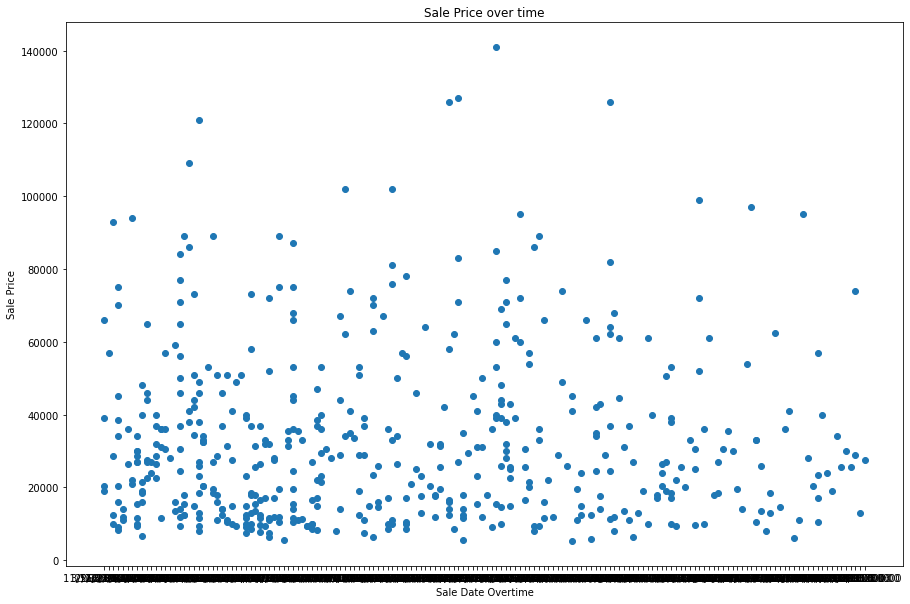

In [8]:
# Sale
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(train_eval['saledate'][:500],train_eval['SalePrice'][:500])
plt.ylabel("Sale Price")
plt.xlabel("Sale Date Overtime")
plt.title("Sale Price over time");

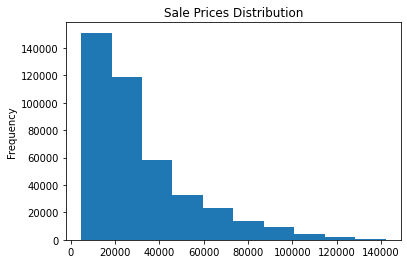

In [9]:
#Distribution of Sale Prices

train_eval['SalePrice'].plot.hist()
plt.title("Sale Prices Distribution");

### Changing date related data to datetime


In [10]:
train_eval['saledate']= pd.to_datetime(train_eval['saledate'])

In [11]:
train_eval['saledate'].head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

#### Sort the dataframe by these dates

In [12]:
train_eval.sort_values(by=['saledate'], inplace=True,ascending=True)
train_eval.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,TD20,TD20,NaN,NaN,NaN,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Direct Drive,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,A66,A66,NaN,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,D7G,D7,G,NaN,NaN,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,A62,A62,NaN,NaN,NaN,NaN,Wheel Loader - Unidentified,Florida,WL,Wheel Loader,NaN,EROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,D3B,D3,B,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
54653,1301884,23500.0,1182999,4123,132,99.0,1976,NaN,NaN,1989-01-31,D6C,D6,C,NaN,NaN,Medium,"Track Type Tractor, Dozer - 130.0 to 160.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
81383,1379228,31000.0,1082797,7620,132,99.0,1986,NaN,NaN,1989-01-31,IT12,IT12,NaN,NaN,NaN,Compact,Wheel Loader - 60.0 to 80.0 Horsepower,Florida,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
204924,1645390,11750.0,1527216,8202,132,99.0,1970,NaN,NaN,1989-01-31,544,544,NaN,NaN,NaN,NaN,Wheel Loader - 90.0 to 100.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
135376,1493279,63000.0,1363756,2759,132,99.0,1987,NaN,NaN,1989-01-31,D5HII,D5,H,II,NaN,Medium,"Track Type Tractor, Dozer - 130.0 to 160.0 Hor...",Florida,TTT,Track Type Tractors,NaN,EROPS,NaN,NaN,NaN,NaN,Powershift,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
113390,1449549,13000.0,12894

### Make a copy of this orignal dataframe

Since we're going to be manipulating the data, we'll make a copy of the original DataFrame and perform our changes there.

This will keep the original DataFrame in tact if we need it again.


In [13]:
df_tmp = train_eval.copy()

### Enrich the dataset

From the `saledate`feature , we can enrich the dataset.
Within this feature there are elements such as :

`saleYear`
`saleMonth`
`saleDay`
`saleDayOfWeek`
`saleDayOfYear`

These can possibly help a machine learning model identify some trends in the data

In [14]:
#Create the above features

df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

#As the original saledate feature is no longer needed , I can remove this now.

df_tmp.pop('saledate')

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
            ...    
410879   2012-04-28
412476   2012-04-28
411927   2012-04-28
407124   2012-04-28
409203   2012-04-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

#### Check out dataset after enriching

In [15]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [16]:
#

### Checking and resolving Nulls in the data.

As seen earlier via the .info() function , ther are coloumns with Null. This can also be seen when viewing the dataset directly

In [17]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

#### Converting Strings(objects) to categories

Before resolving the null values , I will need to convert string features in to categories

In [18]:

df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


A useful way to change feature datatypes is Pandas api.


In [19]:
for label,content in df_tmp.items():
  if pd.api.types.is_string_dtype(content):
    print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


The above columns are all features that need to be converted in to categorical features.


In [20]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [21]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

##### Inspect a category

In [22]:
df_tmp['state'].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

All of our data is categorical and thus we can now turn the categories into numbers.

For example : 

In [23]:
df_tmp['state'].cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

The the `.codes`, we can access the categories numerically.

In [24]:
#Percentages of NA values in features.
((df_tmp.isna().sum()) / len(df_tmp)) *100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

### Impute in Missing Values

From experience with machine learning models. We know two things:

1. All of our data has to be numerical
2. There can't be any missing values

And as we've seen using df_tmp.isna().sum() our data still has plenty of missing values.


##### **Numeric Features**

In [25]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


The above numeric features have null values in them. I will fill in these null values with the median values.



In [26]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():

          #Create a Binary Feature to let us know if the value was null.

          df_tmp[label + "_isMissing"] = pd.isnull(content)

          #Impute the median
          df_tmp[label] = content.fillna(content.median())



In [27]:
#Check once more for any numeric null values in features.
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
        else:
          print(f"No null values in {label}")


No null values in SalesID
No null values in SalePrice
No null values in MachineID
No null values in ModelID
No null values in datasource
No null values in auctioneerID
No null values in YearMade
No null values in MachineHoursCurrentMeter
No null values in saleYear
No null values in saleMonth
No null values in saleDay
No null values in saleDayOfWeek
No null values in saleDayOfYear
No null values in auctioneerID_isMissing
No null values in MachineHoursCurrentMeter_isMissing


##### **Categorical Features**



In [28]:
# Checking the categorical features
for label,content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
      print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [29]:
# Turn these categories in to their numeric counterparts via categories.codes & accounting for the null values

for label,content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
    #Add binary class if data is missing
    df_tmp[label + "_isMissing"] = pd.isnull(content)

    #account for the null (add +1 to categories codes and pandas leave null category codes at -1)
    df_tmp[label] = pd.Categorical(content).codes+1
    


In [30]:
# Checking the categorical features
for label,content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
      content.isna().sum()
  else:
    print(f"There is no NA values in {label}")

There is no NA values in SalesID
There is no NA values in SalePrice
There is no NA values in MachineID
There is no NA values in ModelID
There is no NA values in datasource
There is no NA values in auctioneerID
There is no NA values in YearMade
There is no NA values in MachineHoursCurrentMeter
There is no NA values in UsageBand
There is no NA values in fiModelDesc
There is no NA values in fiBaseModel
There is no NA values in fiSecondaryDesc
There is no NA values in fiModelSeries
There is no NA values in fiModelDescriptor
There is no NA values in ProductSize
There is no NA values in fiProductClassDesc
There is no NA values in state
There is no NA values in ProductGroup
There is no NA values in ProductGroupDesc
There is no NA values in Drive_System
There is no NA values in Enclosure
There is no NA values in Forks
There is no NA values in Pad_Type
There is no NA values in Ride_Control
There is no NA values in Stick
There is no NA values in Transmission
There is no NA values in Turbocharged

In [31]:
df_tmp['state']

205615    44
274835     9
141296     9
212552     9
62755      9
          ..
410879     5
412476     5
411927     5
407124     5
409203     5
Name: state, Length: 412698, dtype: int8


Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!



## Modelling

### Splitting the data

Currently the dataset is both the training and evalutation datset combined.
I will need to split these.

In [32]:
# Splitting data ito x and y and into train and valid datasets
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

np.random.seed(42) # random seed for reproduciblity of the result.

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [33]:
#Importing Modelling libraries I will use :

from  sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from  sklearn.ensemble import RandomForestRegressor
from  sklearn.linear_model import Lasso
from  sklearn.linear_model import Ridge
from sklearn import svm

### Initial model testing

#### Random Forest Regression

In [34]:
rf_reg = RandomForestRegressor()

In [50]:
rf_reg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [51]:
rf_reg.score(X_valid,y_valid)

0.8733402278055247

#### Lasso Regression

In [ ]:
lasso_reg = Lasso()

In [ ]:
lasso_reg.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57701036928425.664, tolerance: 21287598237.442978
  positive)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso_reg.score(X_valid,y_valid)

0.46074005651258804

#### Ridge Regression

In [ ]:
ridge_reg = Ridge()

In [ ]:
ridge_reg.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.64416e-18): result may not be accurate.
  overwrite_a=True).T


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
ridge_reg.score(X_valid,y_valid)

0.46412019476513366

#### XGBoost Regessor

In [35]:
from xgboost import XGBRegressor
xgbr = XGBRegressor()

In [ ]:
xgbr.fit(X_train,y_train)

[14:38:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
xgbr.score(X_valid,y_valid)

0.7561593207954761

### Optimizing Models via GridSearchCV

In [36]:
#Defining parameters for Random Forest:

# Number of trees in random forest
n_estimators = [50,200,350 ]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [10,30,50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


rf_param_grid = { 
    
    'n_estimators':n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf': min_samples_leaf,

}




In [40]:
rf_Randomized_Search = RandomizedSearchCV(rf_reg,param_distributions=rf_param_grid , n_jobs=None,cv=3)

In [41]:
rf_Randomized_Search.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [44]:
rf_Randomized_Search.best_score_

0.6450170513114187

In [45]:
rf_Randomized_Search.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}

### Boosting with XGBoost

In [ ]:
xgbr_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
xgbr_Random_GridSearch = RandomizedSearchCV(xgbr,param_distributions=xgbr_param_grid , n_jobs=-1)

In [ ]:
xgbr_Random_GridSearch.fit(X_train,y_train)

[20:34:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alp...
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                 

In [ ]:
xgbr_Random_GridSearch.best_score_

0.7574875448714804

Looks like I will go with `Random Forest Regressor`.
The original default hyperparameter settings are outperforming the randomized search.

In [46]:
rf_reg.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

In [48]:
rf_Randomized_Search.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}

For the purpose of time , I will simply use the original default random forest model to predict on the validation data.

### Evaluating the predictions on Validation Set

In [59]:
from sklearn.metrics import mean_squared_log_error 

y_pred = rf_reg.predict(X_valid)

y_pred

array([36529.75, 79966.8 , 19090.  , ..., 18527.5 , 67335.  , 38865.  ])

In [61]:
rmsle = np.sqrt(mean_squared_log_error(y_valid,y_pred))

In [62]:
rmsle 

0.25520945351755076

Based off this number on validation set , I would end up around 50th on the Kaggle Competition (Should validation set have been the test set).

## Predict on the test set

In [87]:
test_df = pd.read_csv("/content/drive/MyDrive/Machine Learnning Projects/TimeSeries Projects/BullDozer/data/bluebook-for-bulldozers#/Test.csv",
low_memory=False,
parse_dates=['saledate'])

In [88]:
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [89]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

As we can see the data here is not preprocessed as we did on out training and validation set. Next step will be to do the same preprocessing on this dataset.
Instead of doing all the above again , I will create a function to do this for me.

In [90]:
def preprocess_data(dataset):


  dataset['saleYear'] = dataset.saledate.dt.year
  dataset['saleMonth'] = dataset.saledate.dt.month
  dataset['saleDay'] = dataset.saledate.dt.day
  dataset['saleDayOfWeek'] = dataset.saledate.dt.dayofweek
  dataset['saleDayOfYear'] = dataset.saledate.dt.dayofyear

  #As the original saledate feature is no longer needed , I can remove this now.
  dataset.pop('saledate')

   # This will turn all of the string values into category values & fill in missing value
  for label, content in dataset.items():
    if not pd.api.types.is_numeric_dtype(content):
        dataset[label] = content.astype("category").cat.as_ordered()
	      #Add binary class if data is missing
        dataset[label + "_isMissing"] = pd.isnull(content)

        #account for the null (add +1 to categories codes and pandas leave null category codes at -1)
        dataset[label] = pd.Categorical(content).codes+1

  for label, content in dataset.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
          #Create a Binary Feature to let us know if the value was null.

          dataset[label + "_isMissing"] = pd.isnull(content)

          #Impute the median
          dataset[label] = content.fillna(content.median())

  return dataset

In [91]:
preprocess_data(test_df)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,...,fiModelDescriptor_isMissing,ProductSize_isMissing,fiProductClassDesc_isMissing,state_isMissing,ProductGroup_isMissing,ProductGroupDesc_isMissing,Drive_System_isMissing,Enclosure_isMissing,Forks_isMissing,Pad_Type_isMissing,Ride_Control_isMissing,Stick_isMissing,Transmission_isMissing,Turbocharged_isMissing,Blade_Extension_isMissing,Blade_Width_isMissing,Enclosure_Type_isMissing,Engine_Horsepower_isMissing,Hydraulics_isMissing,Pushblock_isMissing,Ripper_isMissing,Scarifier_isMissing,Tip_Control_isMissing,Tire_Size_isMissing,Coupler_isMissing,Coupler_System_isMissing,Grouser_Tracks_isMissing,Hydraulics_Flow_isMissing,Track_Type_isMissing,Undercarriage_Pad_Width_isMissing,Stick_Length_isMissing,Thumb_isMissing,Pattern_Changer_isMissing,Grouser_Type_isMissing,Backhoe_Mounting_isMissing,Blade_Type_isMissing,Travel_Controls_isMissing,Differential_Type_isMissing,Steering_Controls_isMissing,MachineHoursCurrentMeter_isMissing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,25,0,0,0,2,51,1,1,4,3,2,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,0,0,0,4,57,46,6,6,0,1,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,7,3,0,0,0,...,True,False,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,9,0,33,3,14,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,...,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,13,0,32,3,18,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,...,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,33,0,0,0,48,8,5,5,0,3,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,...,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,44,37,0,6,26,8,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,...,True,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,43,0,0,5,13,8,4,4,0,1,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,...,True,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,Tr

In [92]:
rf_reg.predict(test_df)

ValueError: ignored

Looks like there is a column different in the training than there is in test data.


In [93]:
set(X_train.columns)-set(test_df.columns)

{'auctioneerID_isMissing'}

The above may be missing due to the fact there may have been no Null values in the test set for the feature auctioneerID.

In [95]:
test_df["auctioneerID_isMissing"] = False

Now that it is in the data , it should be able to be predicted on . Finally !!

In [111]:
Test_preds = rf_reg.predict(test_df)

In [112]:
Test_preds[:5]

array([22035. , 22692.5, 47245. , 87170. , 53596. ])

### Reformat Test Predictions to submission format.


In [113]:
submission_df = pd.DataFrame()


In [114]:
submission_df['SalesID'] = test_df.SalesID
submission_df['SalePrice'] = Test_preds

In [115]:
submission_df.head()

,SalesID,SalePrice
0,1227829,22035.0
1,1227844,22692.5
2,1227847,47245.0
3,1227848,87170.0
4,1227863,53596.0


In [116]:
#Export to csv for file submission

submission_df.to_csv('/content/drive/MyDrive/Machine Learnning Projects/TimeSeries Projects/BullDozer/test-predictions.csv', index=False)